In [1]:
!date

Sun Mar  1 23:36:54 PST 2020


# Make 10x gene matrix and perform cluster comparison

In [2]:
import anndata
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
#"Astro" : (0.9019607843137255,  0.3333333333333333,  0.050980392156862744),  # e6550d #reds
#"Endo" : (0.9921568627450981,  0.5529411764705883,  0.23529411764705882 ),  # fd8d3c
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
#"L5/6 NP" : (0.6784313725490196,  0.28627450980392155, 0.2901960784313726 ),  # ad494a
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
#"Low Quality" : (0.5490196078431373,  0.42745098039215684, 0.19215686274509805),  # 8c6d31
#"SMC" : (0.7411764705882353,  0.6196078431372549,  0.2235294117647059 ),  # bd9e39
#"VLMC" : (0.9058823529411765,  0.7294117647058823,  0.3215686274509804 ),  # e7ba52
# (0.9058823529411765,  0.796078431372549,   0.5803921568627451 ),  # e7cb94
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
#"Pvalb" : (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  ),  # 756bb1
#(0.6196078431372549,  0.6039215686274509,  0.7843137254901961  ),  # 9e9ac8
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
#"Pvalb":(0.8549019607843137,  0.8549019607843137,  0.9215686274509803  ),  # dadaeb
}

In [4]:
path = "/home/sina/projects/mop/mop_10xv3"
file_paths = glob.glob(path + "/gene_out*/counts_filtered/adata.h5ad")

In [5]:
file_paths = np.sort(file_paths).tolist()

In [6]:
file_paths

['/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_A01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_B01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_C01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_D01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_E01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_F01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_G12_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_H12_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_190430_01_A08_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_190430_01_B08_S01_L003/counts_fi

In [7]:
batch_id = [
"3L8TX_181211_01_A01",
"4L8TX_181211_01_B01",
"5L8TX_181211_01_C01",
"6L8TX_181211_01_D01",
"7L8TX_181211_01_E01",
"8L8TX_181211_01_F01",
"1L8TX_181211_01_G12",
"2L8TX_181211_01_H12",
"9L8TX_190430_01_A08",    
"10L8TX_190430_01_B08",
"11L8TX_190430_01_F08",    
"12L8TX_190430_01_G08"]

In [8]:
%%time
files = []
for fidx, f in enumerate(file_paths):
    print("{} of {}".format(fidx+1, len(file_paths)))
    files.append(anndata.read_h5ad(f))

1 of 12
2 of 12
3 of 12
4 of 12
5 of 12
6 of 12
7 of 12
8 of 12
9 of 12
10 of 12
11 of 12
12 of 12
CPU times: user 1.31 s, sys: 2.69 s, total: 3.99 s
Wall time: 3.98 s


In [9]:
adata = files[0].concatenate(*files[1:], batch_categories=batch_id)

In [10]:
adata

AnnData object with n_obs × n_vars = 169200 × 31053 
    obs: 'batch'
    var: 'gene_name'

In [11]:
adata.obs.head()

,batch
AAACCCAAGGTGTGAC-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCAAGTTGGACG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACACAAACGG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACAGACACAG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACAGCGCTTG-3L8TX_181211_01_A01,3L8TX_181211_01_A01


In [12]:
ca = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.annotation.csv", index_col=0)
cm = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.membership.csv", index_col=0)

In [13]:
adata = adata[adata.obs.index.isin(cm.index)]

In [14]:
adata.obs["cluster_id"] = adata.obs.index.map(cm["x"])

Trying to set attribute `.obs` of view, copying.


In [15]:
adata.obs["cluster_label"]  = adata.obs["cluster_id"].map(ca["cluster_label"])
adata.obs["subclass_label"] = adata.obs["cluster_id"].map(ca["subclass_label"])
adata.obs["class_label"]    = adata.obs["cluster_id"].map(ca["class_label"])

In [16]:
le = LabelEncoder()
adata.obs["cluster_id"] = le.fit_transform(adata.obs.cluster_label.values)

le = LabelEncoder()
adata.obs["subclass_id"] = le.fit_transform(adata.obs.subclass_label.values)

le = LabelEncoder()
adata.obs["class_id"] = le.fit_transform(adata.obs.class_label.values)

In [17]:
adata.obs.cluster_label.nunique()

147

In [18]:
adata

AnnData object with n_obs × n_vars = 94162 × 31053 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'gene_name'

In [19]:
adata.var["gene_id"] = adata.var.index.str.slice(0,18).values
adata.var["gene_short_name"] = adata.var["gene_name"]
adata.var["gene_name"] = adata.var["gene_short_name"] + "_"+ adata.var['gene_id']

In [20]:
adata.var.index = adata.var["gene_name"].values

In [7]:
ss = anndata.read_h5ad("../cell_ranger_annotation/gene.h5ad")

In [22]:
ss.var.head()

,transcript_id,gene_id,gene_name,transcript_name,length,txn_list,num_isoforms,gene_counts,dispersion,pass_disp_filter,highly_variable,means,dispersions,dispersions_norm
Xkr4_ENSMUSG00000051951,ENSMUST00000162897,ENSMUSG00000051951,Xkr4_ENSMUSG00000051951,Xkr4-203_ENSMUST00000162897,4153,"['ENSMUST00000162897', 'ENSMUST00000159265', '...",3,31.178135,0.024002,True,False,1.709229,3.049753,-0.363077
Gm1992_ENSMUSG00000089699,ENSMUST00000161581,ENSMUSG00000089699,Gm1992_ENSMUSG00000089699,Gm1992-201_ENSMUST00000161581,250,['ENSMUST00000161581'],1,16.115997,0.044208,True,False,1.113236,3.501799,0.329747
Gm37381_ENSMUSG00000102343,ENSMUST00000192427,ENSMUSG00000102343,Gm37381_ENSMUSG00000102343,Gm37381-201_ENSMUST00000192427,899,['ENSMUST00000192427'],1,7.708817,0.011218,True,False,0.664979,2.314652,-0.673724
Gm37323_ENSMUSG00000104328,ENSMUST00000195771,ENSMUSG00000104328,Gm37323_ENSMUSG00000104328,Gm37323-201_ENSMUST00000195771,2773,['ENSMUST00000195771'],1,1.687474,0.001286,True,False,0.186042,0.032763,-1.929119
Mrpl15_ENSMUSG00000033845,ENSMUST00000130201,ENSMUSG00000033845,Mrpl15_ENSMUSG00000033845,Mrpl15-203_ENSMUST00000130201,1894,"['ENSMUST00000130201', 'ENSMUST00000156816', '...",7,1245.200195,0.091864,True,False,5.074990,3.705464,-0.507727


In [23]:
adata.var.head()

,gene_name,gene_id,gene_short_name
Xkr4_ENSMUSG00000051951,Xkr4_ENSMUSG00000051951,ENSMUSG00000051951,Xkr4
Gm1992_ENSMUSG00000089699,Gm1992_ENSMUSG00000089699,ENSMUSG00000089699,Gm1992
Gm37381_ENSMUSG00000102343,Gm37381_ENSMUSG00000102343,ENSMUSG00000102343,Gm37381
Rp1_ENSMUSG00000025900,Rp1_ENSMUSG00000025900,ENSMUSG00000025900,Rp1
Sox17_ENSMUSG00000025902,Sox17_ENSMUSG00000025902,ENSMUSG00000025902,Sox17


In [24]:
ss = ss[:,ss.var.sort_index().index]
adata = adata[:,adata.var.sort_index().index]

In [25]:
ss.var.head()

,transcript_id,gene_id,gene_name,transcript_name,length,txn_list,num_isoforms,gene_counts,dispersion,pass_disp_filter,highly_variable,means,dispersions,dispersions_norm
0610005C13Rik_ENSMUSG00000109644,ENSMUST00000210383,ENSMUSG00000109644,0610005C13Rik_ENSMUSG00000109644,0610005C13Rik-204_ENSMUST00000210383,897,"['ENSMUST00000210383', 'ENSMUST00000210866', '...",3,6.056491,0.032505,True,True,0.589889,3.585336,0.721776
0610009B22Rik_ENSMUSG00000007777,ENSMUST00000007921,ENSMUSG00000007777,0610009B22Rik_ENSMUSG00000007777,0610009B22Rik-201_ENSMUST00000007921,813,"['ENSMUST00000007921', 'ENSMUST00000109098']",2,1291.599365,0.115991,True,False,5.111177,4.082575,0.109426
0610009O20Rik_ENSMUSG00000024442,ENSMUST00000025314,ENSMUSG00000024442,0610009O20Rik_ENSMUSG00000024442,0610009O20Rik-201_ENSMUST00000025314,2404,['ENSMUST00000025314'],1,24.198484,0.015614,True,False,1.434486,2.481241,-0.828534
0610010F05Rik_ENSMUSG00000042208,ENSMUST00000155903,ENSMUSG00000042208,0610010F05Rik_ENSMUSG00000042208,0610010F05Rik-207_ENSMUST00000155903,2569,"['ENSMUST00000155903', 'ENSMUST00000043356', '...",8,346.133636,0.050185,True,False,3.790756,3.360925,-0.658245
0610010K14Rik_ENSMUSG00000020831,ENSMUST00000135390,ENSMUSG00000020831,0610010K14Rik_ENSMUSG00000020831,0610010K14Rik-211_ENSMUST00000135390,768,"['ENSMUST00000135390', 'ENSMUST00000134700', '...",14,716.086548,0.081118,True,False,4.537365,3.954600,0.099227


In [26]:
adata.var.head()

,gene_name,gene_id,gene_short_name
0610005C13Rik_ENSMUSG00000109644,0610005C13Rik_ENSMUSG00000109644,ENSMUSG00000109644,0610005C13Rik
0610006L08Rik_ENSMUSG00000108652,0610006L08Rik_ENSMUSG00000108652,ENSMUSG00000108652,0610006L08Rik
0610009B22Rik_ENSMUSG00000007777,0610009B22Rik_ENSMUSG00000007777,ENSMUSG00000007777,0610009B22Rik
0610009O20Rik_ENSMUSG00000024442,0610009O20Rik_ENSMUSG00000024442,ENSMUSG00000024442,0610009O20Rik
0610010F05Rik_ENSMUSG00000042208,0610010F05Rik_ENSMUSG00000042208,ENSMUSG00000042208,0610010F05Rik


In [27]:
adata.write_h5ad("../cell_ranger_annotation/10xv3_gene.h5ad")

Trying to set attribute `.obs` of view, copying.
... storing 'cluster_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subclass_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'class_label' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_short_name' as categorical


In [6]:
adata = anndata.read_h5ad("../cell_ranger_annotation/10xv3_gene.h5ad")

In [10]:
ss = ss[:,ss.var.sort_index().index]

In [8]:
tenx = adata[:,adata.var.index.isin(ss.var.index)]

In [9]:
tenx = tenx[:,tenx.var.sort_index().index]

# Number of cells per cluster

In [11]:
tenx.obs["cell_id"] = tenx.obs.index.values

Trying to set attribute `.obs` of view, copying.


In [12]:
cluster_cmap["doublet"] = (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  )  # 756bb1
cluster_cmap["Macrophage"] =     (0.6196078431372549,  0.6039215686274509,  0.7843137254901961  )  # 9e9ac8
cluster_cmap["OPC"] =     (0.7372549019607844,  0.7411764705882353,  0.8627450980392157  )  # bcbddc
cluster_cmap["Oligo"] =     (0.8549019607843137,  0.8549019607843137,  0.9215686274509803  )  # dadaeb

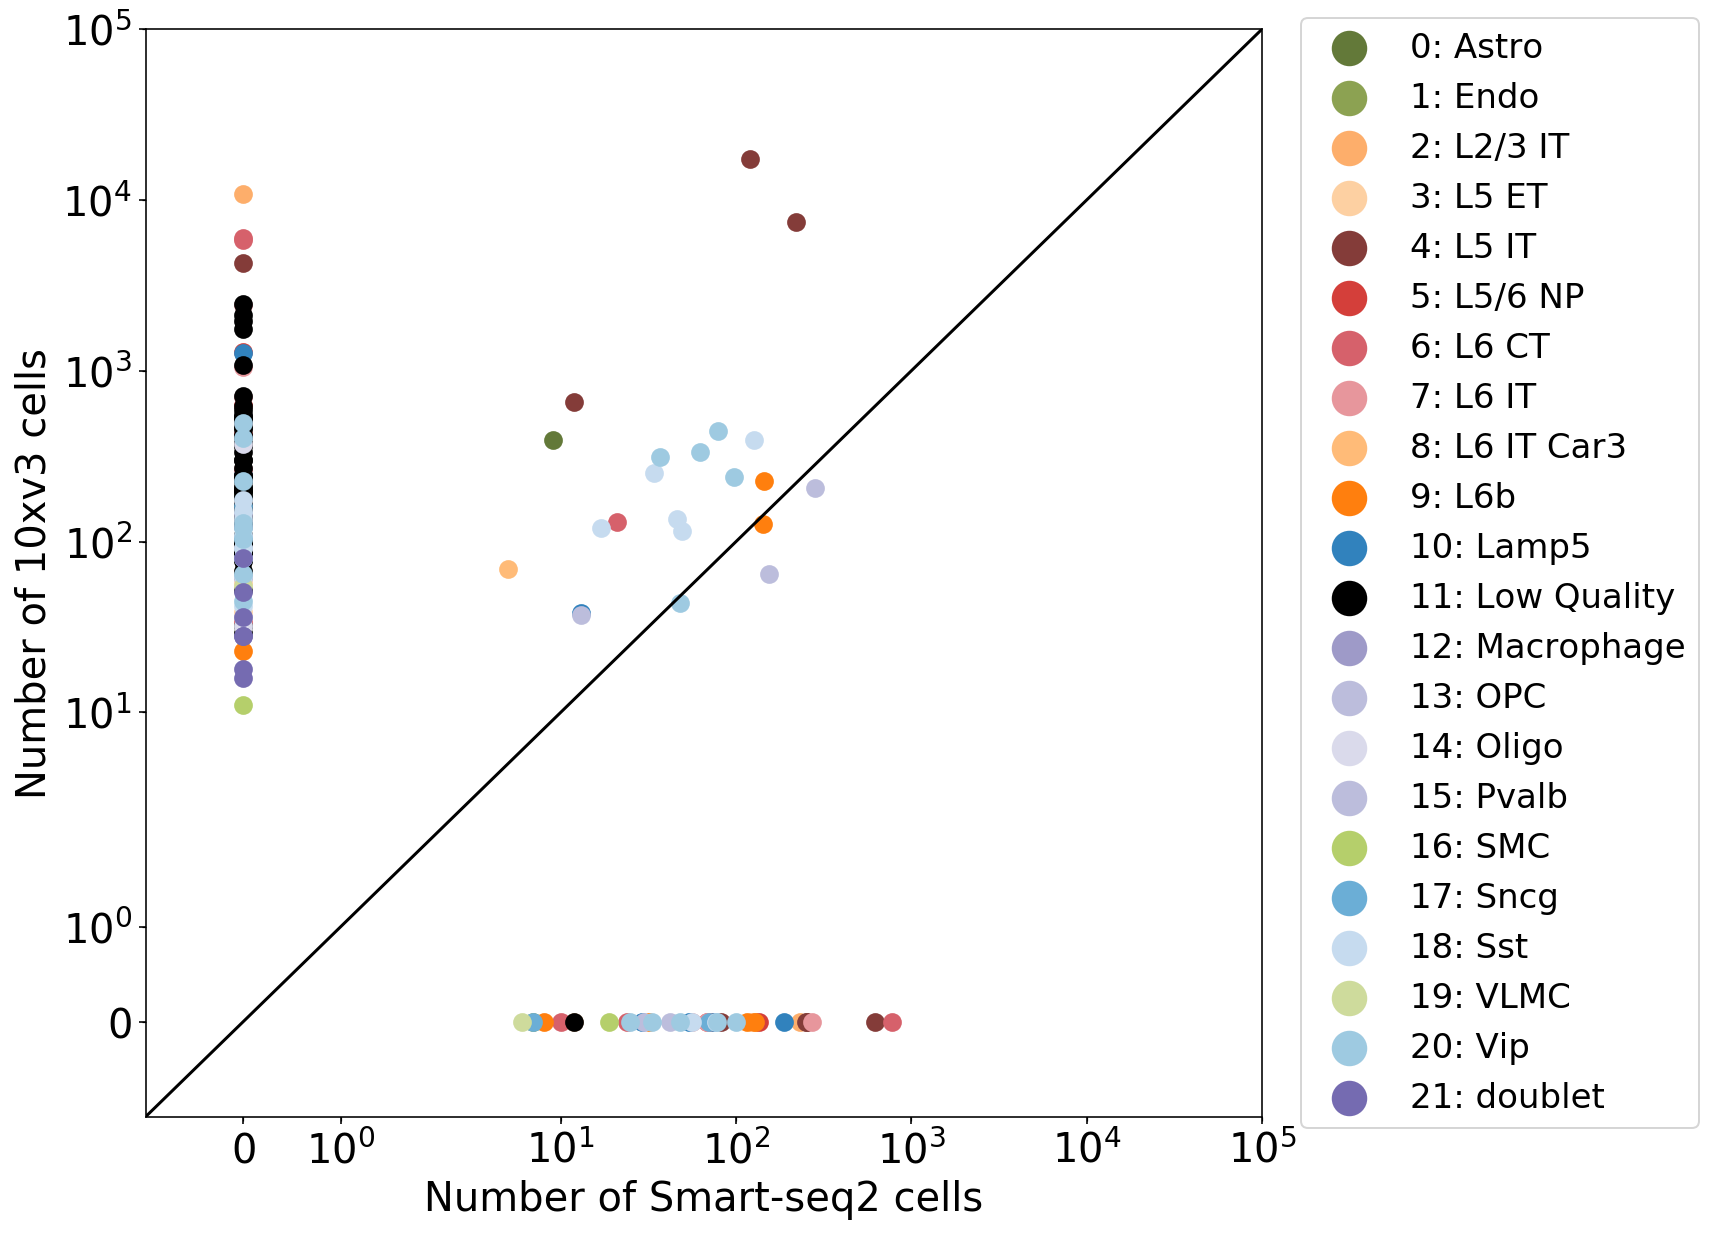

In [13]:
fig, ax = plt.subplots(figsize=(10,10))

ss_labels = ss.obs.groupby("subclass_label").count()["cell_id"].index
tenx_labels = tenx.obs.groupby("subclass_label").count()["cell_id"].index

size=70
for lidx, l in enumerate(tenx_labels):
    if l not in ss_labels:

        y = tenx[tenx.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        x = np.zeros_like(y)
        
        ax.scatter(x, y, color = cluster_cmap[l], label="{}: {}".format(lidx, l), s=size)
    else: 
            
        x = ss[ss.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        y = tenx[tenx.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        union = np.union1d(x.index, y.index)
        
        x_idx = [np.where(union==i)[0][0] for i in x.index]
        y_idx = [np.where(union==i)[0][0] for i in y.index]
        
        xx = np.zeros_like(union)
        xx[x_idx] = x.values
        
        yy = np.zeros_like(union)
        yy[y_idx] = y.values
        
        ax.scatter(xx, yy, color=cluster_cmap[l], label="{}: {}".format(lidx, l), s=size)
        
        
        
ax.plot([-1,10**5], [-1,10**5], color="k")
ax.set_yscale('symlog')
ax.set_xscale('symlog')


ax.set_xlim(-1, 10**5)
ax.set_ylim(-1, 10**5)


ax.legend(loc="center left", bbox_to_anchor=(1.02,0.5), markerscale=2, fontsize=17)

ax.set_xlabel("Number of Smart-seq2 cells")
ax.set_ylabel("Number of 10xv3 cells")
#plt.savefig("./figures/10x_ss_celltypes.png", bbox_inches='tight',dpi=300)

plt.show()

In [33]:
tenx_cluster = np.unique(tenx.obs.cluster_label)
ss_cluster = np.unique(ss.obs.cluster_label)

union = np.union1d(tenx_cluster, ss_cluster)

In [34]:
x = np.zeros_like(union)
y = np.zeros_like(union)

In [35]:
ind = ss.obs.cluster_label.value_counts().index
val = ss.obs.cluster_label.value_counts().values

In [36]:
vc_index = np.where(np.in1d(union, ind))[0]
x[vc_index] = val

In [37]:
ind = tenx.obs.cluster_label.value_counts().index
val = tenx.obs.cluster_label.value_counts().values

In [38]:
vc_index = np.where(np.in1d(union, ind))[0]
y[vc_index] = val

In [39]:
x

array([781, 623, 0, 0, 0, 0, 0, 0, 282, 271, 254, 0, 0, 0, 251, 0, 0, 0,
       0, 0, 231, 219, 0, 0, 189, 0, 0, 154, 0, 144, 0, 0, 142, 136, 129,
       128, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 127, 123, 120, 0, 0, 0, 115,
       100, 97, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 82, 79, 78, 77, 0, 0, 0, 0,
       0, 0, 75, 71, 0, 70, 68, 68, 62, 0, 0, 56, 56, 0, 0, 54, 0, 0, 49,
       0, 0, 0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0,
       46, 0, 0, 42, 0, 0, 37, 34, 0, 33, 32, 30, 0, 0, 29, 0, 0, 0, 0, 0,
       25, 24, 0, 21, 0, 0, 0, 19, 0, 0, 0, 0, 0, 17, 0, 13, 0, 0, 0, 0,
       0, 0, 0, 13, 0, 12, 0, 0, 0, 0, 0, 12, 12, 10, 0, 0, 9, 0, 8, 0, 7,
       0, 0, 0, 0, 7, 0, 6, 0, 0, 0, 5, 0], dtype=object)

In [40]:
tenx.obs.groupby("subclass_label")["cluster_label"].value_counts()

subclass_label  cluster_label     
Astro           Astro Aqp4              395
Endo            Endo Slc38a5_1          187
L2/3 IT         L2/3 IT               10915
L5 ET           L5 ET_1                  65
                L5 ET_3                  57
                                      ...  
doublet         Endo Slc38a5_5           36
                Ex Endo                  28
                L6 IT Car3_Inh           28
                Endo_VLMC                18
                Oligo Opalin_neuon       16
Name: cluster_label, Length: 147, dtype: int64

In [14]:
diff = np.setdiff1d(ss.obs.cluster_label, tenx.obs.cluster_label)

In [15]:
diff.shape

(40,)

In [16]:
diff

array(['Endo Slc38a5', 'L2/3 IT Cdh13 Sla', 'L2/3 IT Macc1',
       'L2/3 IT S100a6', 'L5 ET', 'L5 IT Rspo1', 'L5 IT Rspo2',
       'L5 IT S100b_1', 'L5 IT S100b_2', 'L5 IT Tcap_low',
       'L5 NP Slc17a8', 'L6 CT Grp_1', 'L6 CT Grp_2', 'L6 CT Nxph2_1',
       'L6 CT Nxph2_2', 'L6 IT Sulf_1', 'L6 IT Sulf_2', 'L6 IT Sulf_3',
       'L6 NP Trh', 'L6b Kcnip1_1', 'L6b Kcnip1_2', 'L6b Ror1_1',
       'L6b Ror1_2', 'Lamp5 Egln3_1', 'Lamp5 Egln3_2', 'Lamp5 Pdlim5',
       'Lamp5 Slc35d3', 'Pvalb Gpr149', 'Pvalb Th', 'SMC Aoc3', 'Sncg',
       'Sncg Slc17a8', 'Sst C1ql3', 'Sst Etv1', 'VLMC', 'Vip Chat_1',
       'Vip Chat_2', 'Vip Chat_3', 'Vip Htr1f', 'Vip Lmo1'], dtype=object)

In [28]:
diff = np.setdiff1d(tenx.obs.cluster_label, ss.obs.cluster_label)

In [29]:
diff.shape

(125,)

In [30]:
diff

array(['Endo Slc38a5_1', 'Endo Slc38a5_5', 'Endo_VLMC', 'Ex Endo',
       'Ex Inh', 'L2/3 IT', 'L2/3 IT S100a6 _1_low',
       'L2/3 IT S100a6 _2_low', 'L2/3 IT low', 'L5 ET_1', 'L5 ET_1_low',
       'L5 ET_2', 'L5 ET_2_low', 'L5 ET_3', 'L5 IT Rspo1_1_low',
       'L5 IT Rspo1_2_low', 'L5 IT Rspo2_3_low', 'L5 IT S100b',
       'L5 IT S100b_1_low', 'L5 IT S100b_2_low', 'L5 IT S100b_3_low',
       'L5 NP Slc17a8_1', 'L5 NP Slc17a8_2', 'L5 NP Slc17a8_3',
       'L5 NP Slc17a8_low_1', 'L5 NP Slc17a8_low_2',
       'L5 NP Slc17a8_low_3', 'L6 CT Cpa6_1', 'L6 CT Cpa6_2',
       'L6 CT Cpa6_2_low', 'L6 CT Cpa6_low', 'L6 CT Nxph2 Kit',
       'L6 CT Nxph2 Pou3f2_1', 'L6 CT Nxph2 Pou3f2_2', 'L6 IT Car3_Inh',
       'L6 IT Sulf1_1', 'L6 IT Sulf1_1_low', 'L6 IT Sulf1_2',
       'L6 IT Sulf1_2_low', 'L6 IT Sulf1_3', 'L6 IT Sulf1_3_low',
       'L6 IT Sulf1_4', 'L6 IT Sulf1_4_low', 'L6 IT Sulf1_5_low',
       'L6 NP Trh_1', 'L6 NP Trh_2', 'L6 NP Trh_3', 'L6 NP Trh_Oligo',
       'L6 NP Trh_low', 'L6